# Transformers 

for Natural Language Processing

Author: Roy T. Forestano

Began: 23 September 2025

Notes from the book Deep Learning with Python by Francois Chollet. Code suggested but modified considerably and written in PyTorch as opposed to Keras, as in the text.

### 11.4 The Transformer Architecture

 - Introduced in 2017 by Vaswani et al. in Attention is all you need: https://arxiv.org/abs/1706.03762
 - Neural attention mechanism for sequence models
  Revolution in NLP and beyond

11.4.1 Understanding self-attention

- Not all input information seen by a model is equally important to the task at hand
- Pay more attention to some features and less to others
    - Example 1: Max pooling in convnets keeps the most important value
    - Example 2: TF-IDF assigns importance scores to tokens
- Attention starts by computing importance scores:
    - Higher scores for relevant features
    - Lower scores for less relevant ones
    - Also has the ability to make features *context aware*
- Self-attention
    - Words can change meaning depending on context
    - Provides a different vector representation for a word depending on the other words surrounding it
    - Modulates the representation of a token by using the representations of related tokens in the sequence
    - But ignores word order, only aware of cross-word interactions (need positional encoding)

- Step 1: Compute relevancy scores between each word and the other words through dot products (covariance, A@A.T, $A_{ij}A_{jk}^T$)
    - In practice, also apply a scaling function and softmax
- Step 2: weighted sum of all word vectors forms new word vector for each word $softmax(A_{ij}A_{jk}^T)/\sqrt{D} A_{kl}$


|  | Word order awareness | Context awareness (cross-word interactions) |
| --- | --- | --- |
| Bag of unigrams| No | No |
| Bag of bigrams| Very limited | No |
| RNN | Yes | No |
| Self-attention | No| Yes |
| Transformer | Yes | Yes |



In [ ]:
'''
def self_attention(inputs):
    # inputs.shape = (# words/tokens, embed dim)
    scores = softmax(inputs@inputs.T/np.sqrt(inputs.shape[1]))
    return scores@inputs
'''

Generalized Self-Attention: The Query-Key-Value Model

so far

$outputs = sum(pairwise score(inputs_{A}, inputs_{B})*inputs_{C})$

which reads for each input $A$, compute how much the token is related to every token in $B$, and use these scores to weight a sum of tokens from inputs $C$. 

- There is no requirement that A,B,C need to be the same input sequence
- A: query
- B: key
- C: value
- A,B,C trainable (A for hidden dim only, I imagine)
- Terminology comes from search engines and recommender systems

We now have for each element in the query, compute how much the element is related to every key, and use these scores to weight a sum of values

$outputs = sum(pairwise score(query, key)*value)$


The logic
- Query: reference seuqnece which describes something you are looking for
- Key: key describes values in the format which can be compared to the query
- Value: body of knowledge you want to extract information from
- Match query to keys and return a weighted sum of values

Notes
- Keys and values often the same sequence
- Machine translation: query is the target sequence, source would be keys and values
- Sequence classification: query, keys, values all same (comapring sequence to itself to enrich each token with context from the whole sequence)


11.4.2 Multi-head attention

- output space of the self-attention layer gets factored into a set of independent subspaces (heads), learned separatelty
- initial query, key, and value are sent through three independent sets of dense projections (learnable), resulting in three separate vectors
- each vector is processed via neural attention 
- three outputs are concatenated back together into a single output sequence
- Each subspace is called a head

- Learnable dense projections enable training rather than being a stateless transformation which would require additional layers before or after it
- Independent heads helps the layer learn different groups of features for each token
    - Feature in one group correlated
    - Independent from features in a different group
- Factoring feature spaces into independent subspaces
    - Benefits for comp-vision, e.g. depthwise separable convolutions, grouped convolutions
    Multi-head attention is the same idea applied to self-attention

11.4.3 The Transformer encoder

- Transformer encoder: processes the source sequence
- Transformer decoder: uses source sequence to generate new text

Key components for complex models
- Factoring outputs into multiple independent spaces
- Adding residual connections
- Adding normalization layers

$$T^{d_sd_s \times d_sd_t}= I_{d_s} \otimes W_U^{d_s \times d_e} W_E^{d_e \times d_t } + \sum_{h \in H} A^{h,d_s \times d_s} \otimes (W_U^{d_s \times d_e} W_{OV}^{h, d_e \times d_e} W_E^{d_e \times d_t })$$

where

$$A^{h, d_s \times d_s} = softmax\left( t^{d_s \times d_t} W_E^{d_t \times d_e } W_{QK}^{h,d_e \times d_e} W_E^{d_e \times d_t } t^{d_t \times d_s}  \right)$$

and

$s$ is sequence, $t$ is token dimension, $e$ is embedding dimension.

Batch vs Layer Normalization

- Batch Normalization
    - collects information from many samples to obtain accurate statistics for feature means and variances
    - More appropriate for non-sequential data


- Layer Normalization
    - pools data within each sequence separtely
    - More appropriate for sequence data

Positional Embedding

Using positional encoding to re-inject order information

- Give model access to word information 
- Use word position index in embedding, as well (add it)
- Input word embedding shave two components
    - usual word vector representing the word independently of any specific context
    - position vector representing position of word in sentence

Examples
- Trigonometric embeddings
- Learned embeddings

- MultiheadAttention: https://docs.pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
- LayerNorm: https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
- MaxPool1d: https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html
- BCELoss: https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#bceloss
- CrossEntropyLoss: https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

## TransformerEncoder: Sequence classification learning

11.4.4 When to use sequence models over bag-of-words models (for text classification ONLY)

- Look at the ratio between the number of samples in the training data and the mean number of words per sample
    - If small (~<1500), bag-of-bigrams (better, faster to train and iterate on)
    - Otherwise, sequence model (needs lots of training data, each sample relatively short)

- Sequence model inputs represent a richer and more complex space
    - Takes more data to map out that space
    - The shorter a sample, the more important it is to retain as much infromation as possible. Word order is more important.
- Set models have a simpler input space
    - Train a logistic regression
    - In a longer sample, word statistics would become more reliable. Topic would be apparent from word histogram alone

In [1]:
import numpy as np
print('Original: ',np.random.randint(0,2,size=(6,10,20)).shape)
# Layer Normalization
def layer_normalization(batch_of_sequences):
    mean = np.mean(batch_of_sequences, keepdims=True, axis=-1)
    variance = np.var(batch_of_sequences, keepsimd=True, axis=-1)
    return (batch_of_sequences-mean)/variance

print('Layer Means: ',np.mean(np.random.randint(0,2,size=(6,10,20)), keepdims=True, axis=-1).shape)

def batch_normalization(batch_of_images):
    mean = np.mean(batch_of_images, keepdims=True, axis=(0,1,2))
    variance = np.var(batch_of_images, keepsimd=True, axis=(0,1,2))
    return (batch_of_images-mean)/variance

print('Batch Mean: ',np.mean(np.random.randint(0,2,size=(6,10,20)), keepdims=True, axis=(0,1,2)).shape)

Original:  (6, 10, 20)
Layer Means:  (6, 10, 1)
Batch Mean:  (1, 1, 1)


In [2]:
from utils import *
ngram_size = 1
max_vocab_length = 20000
batch_size = 32
train_loader, val_loader, test_loader, vocab, max_seq_length = get_data(ngram_size,
                                                                        max_vocab_length,
                                                                        batch_size)

Device:  cpu
Text: stage adaptations often have a major fault they often come out looking like a film camera was simply placed on the stage such as night mother sidney lumets direction keeps the film alive which is especially difficult since the picture offered him no real challenge still its nice to look at for what it is the chemistry between michael caine and christopher reeve is quite brilliant the dynamics of their relationship are surprising caine is fantastic as always and reeve gets one of his few chances to really actbr br i confess that ive never seen ira levins play but i hear that jay presson allens adaptation is faithful the script is incredibly convoluted and keeps you guessing deathtrap is an enormously entertaining film and is recommended for nearly all fans of stage and screenbr br 74 out of 10
Label: 1
Tokens: ['stage', 'adaptations', 'often', 'have', 'a', 'major', 'fault', 'they', 'often', 'come']


In [3]:
torch.manual_seed(0)
# Model Hyperparameters
epochs = 10
learning_rate = 1e-3 # want this to be 10^-2 - 10^-4
hidden_dim = 16 # defines hidden dense layer size
embed_dim = 128 # If using OneHot = len(vocab)
att_heads = 2
# Initialize model and optimizer
model = TransformerClassifier(hidden_dim = hidden_dim, 
                             vocab = vocab, 
                             embed_dim = embed_dim,
                             num_heads=att_heads,
                             max_seq_length=max_seq_length).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss() #BCELoss

In [4]:
number_of_parameters = 0
for i,params in enumerate(model.parameters()):
  number_of_parameters += params.flatten().shape[0]
print('Number of Parameters: ', number_of_parameters)

Number of Parameters:  5506961


In [5]:
torchinfo.summary(model, 
                  input_data=(torch.randint(0,len(vocab),(batch_size,max_seq_length)), 
                                torch.randint(1,max_seq_length,(batch_size,)) ),
                   col_names=["input_size", "output_size", "num_params", "trainable"],
                   depth=3                  
                   )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
TransformerClassifier                    [32, 2469]                [32, 1]                   --                        True
├─PositionalEmbedding: 1-1               [32, 2469]                [32, 2469, 128]           --                        True
│    └─Embedding: 2-1                    [32, 2469]                [32, 2469, 128]           2,560,000                 True
│    └─Embedding: 2-2                    [32, 2469]                [32, 2469, 128]           316,032                   True
├─TransformerEncoder: 1-2                [32, 2469, 128]           [32, 2469, 128]           2,560,000                 True
│    └─MultiheadAttention: 2-3           --                        [32, 2469, 128]           66,048                    True
│    └─LayerNorm: 2-4                    [32, 2469, 128]           [32, 2469, 128]           256                       True
│  

In [6]:
training_history = training(train_loader,
                            val_loader,
                            epochs,
                            loss_fn,
                            model,
                            optimizer,
                            regularize = False)

 10%|█         | 1/10 [02:35<23:18, 155.36s/it]

Epoch: 0 | Train Loss: 0.74141794 | Val Loss: 0.70077599 | Best Val Loss: 0.70077599 | Accuracy: 0.49860000


 20%|██        | 2/10 [05:16<21:10, 158.85s/it]

Epoch: 1 | Train Loss: 0.69760959 | Val Loss: 0.69100728 | Best Val Loss: 0.69100728 | Accuracy: 0.55360000


 30%|███       | 3/10 [08:09<19:16, 165.18s/it]

Epoch: 2 | Train Loss: 0.69861176 | Val Loss: 0.69353417 | Best Val Loss: 0.69100728 | Accuracy: 0.50780000


 40%|████      | 4/10 [11:16<17:22, 173.69s/it]

Epoch: 3 | Train Loss: 0.69373831 | Val Loss: 0.68850060 | Best Val Loss: 0.68850060 | Accuracy: 0.53700000


 50%|█████     | 5/10 [14:24<14:55, 179.09s/it]

Epoch: 4 | Train Loss: 0.69079151 | Val Loss: 0.68450539 | Best Val Loss: 0.68450539 | Accuracy: 0.54560000


 60%|██████    | 6/10 [17:36<12:13, 183.29s/it]

Epoch: 5 | Train Loss: 0.68767283 | Val Loss: 0.68262394 | Best Val Loss: 0.68262394 | Accuracy: 0.53000000


 70%|███████   | 7/10 [20:45<09:16, 185.34s/it]

Epoch: 6 | Train Loss: 0.68232868 | Val Loss: 0.68938341 | Best Val Loss: 0.68262394 | Accuracy: 0.50140000


 80%|████████  | 8/10 [23:59<06:16, 188.07s/it]

Epoch: 7 | Train Loss: 0.67870813 | Val Loss: 0.67896902 | Best Val Loss: 0.67896902 | Accuracy: 0.54040000


 90%|█████████ | 9/10 [27:16<03:10, 190.82s/it]

Epoch: 8 | Train Loss: 0.67598600 | Val Loss: 0.66684501 | Best Val Loss: 0.66684501 | Accuracy: 0.59060000


100%|██████████| 10/10 [30:35<00:00, 183.52s/it]

Epoch: 9 | Train Loss: 0.65291517 | Val Loss: 0.63944607 | Best Val Loss: 0.63944607 | Accuracy: 0.63240000
Training Complete. Total Time (s): 1835.1740000247955


### Evaluate Model

In [13]:
# --- Saving ---
# torch.save(model.state_dict(), "weights/binaryclassifier_transformer_model.pth")

# --- Loading ---
# create model instance
model = TransformerClassifier(hidden_dim = hidden_dim, 
                             vocab = vocab, 
                             embed_dim = embed_dim,
                             num_heads=att_heads,
                             max_seq_length=max_seq_length).to(device)
model.load_state_dict(torch.load("weights/binaryclassifier_transformer_model.pth"))
model.eval()   # set to eval mode for inference

TransformerClassifier(
  (embed): PositionalEmbedding(
    (embed_words): Embedding(20000, 128, padding_idx=0)
    (embed_positions): Embedding(2469, 128)
  )
  (transformer_encoder): TransformerEncoder(
    (embed): Embedding(20000, 128, padding_idx=0)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (dense_proj): Sequential(
      (0): Linear(in_features=128, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=128, bias=True)
    )
    (layernorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (layernorm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [14]:
training_history['history'].keys()

dict_keys(['train_loss', 'val_loss', 'accuracy', 'weights', 'components_loss'])

In [15]:
# np.save(data_path+f'train_su{2**qubit_number}_su{2**mod_fraction}_lay{n_layers}_ep{epochs}_lr{lr}_param{count}.npy',model_history['history']['train_loss'])
# np.save(data_path+f'weights_su{2**qubit_number}_su{2**mod_fraction}_lay{n_layers}_ep{epochs}_lr{lr}_param{count}.npy',model_history['history']['weights'][0])

Text(0.5, 0, 'Epoch')

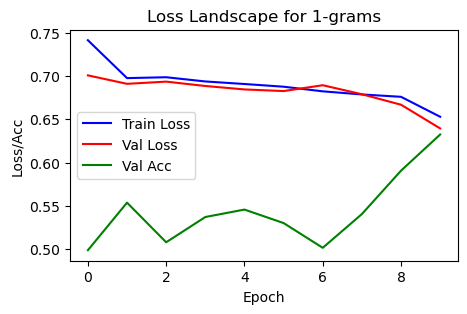

In [16]:
plt.figure(figsize=(5,3))
epoch_list = [i for i in range(epochs)]
plt.plot(epoch_list,training_history['history']['train_loss'],label= 'Train Loss',c='b')
plt.plot(epoch_list,training_history['history']['val_loss'],label= 'Val Loss',c='r')
plt.plot(epoch_list,training_history['history']['accuracy'], label = 'Val Acc',c='g')
plt.legend()
plt.title(f'Loss Landscape for {ngram_size}-grams')
plt.ylabel('Loss/Acc')
plt.xlabel('Epoch')
# plt.savefig("loss.png", bbox_inches="tight")

Check Test Data
- Confusion Matrix
- Accuracy
- ROC Curve
- ROC AUC Score
- PR AUC Curve
- PR Score
- F1 Score

In [17]:
correct_predictions = 0
total_predictions = 0
model.to(device)
model.eval()
with torch.inference_mode():
        for batch_idx, batch in enumerate(test_loader):#tqdm(enumerate(train_loader)):
                input_data = batch['tokens'].to(device).to(torch.float64)
                lengths_data = batch['lengths'].to(device)
                label_data = batch['label'].to(device).to(torch.float64).unsqueeze(1)
                
                predictions = (model(input_data,lengths_data)>0.5).long()
                correct_predictions += (label_data.long()==predictions).sum().item()
                total_predictions += label_data.shape[0]

accuracy = correct_predictions / total_predictions
print('Test Accuracy: ', accuracy)

Test Accuracy:  0.61448


              precision    recall  f1-score   support

         0.0     0.7343    0.3620    0.4849     12500
         1.0     0.5767    0.8690    0.6933     12500

    accuracy                         0.6155     25000
   macro avg     0.6555    0.6155    0.5891     25000
weighted avg     0.6555    0.6155    0.5891     25000



<Figure size 500x400 with 0 Axes>

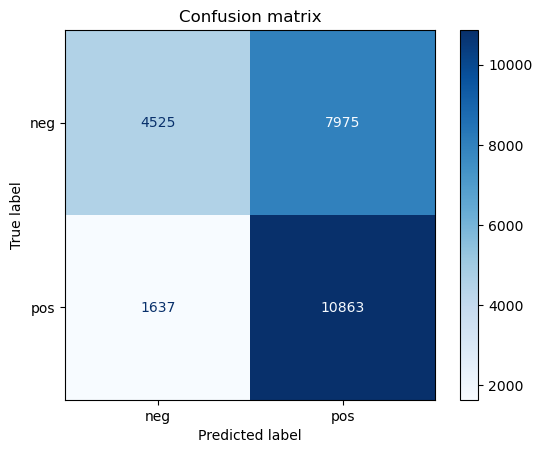

<Figure size 500x400 with 0 Axes>

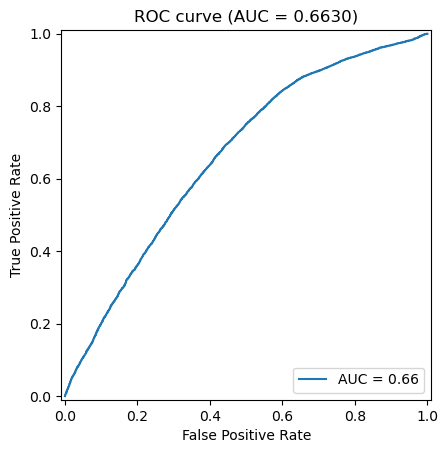

<Figure size 500x400 with 0 Axes>

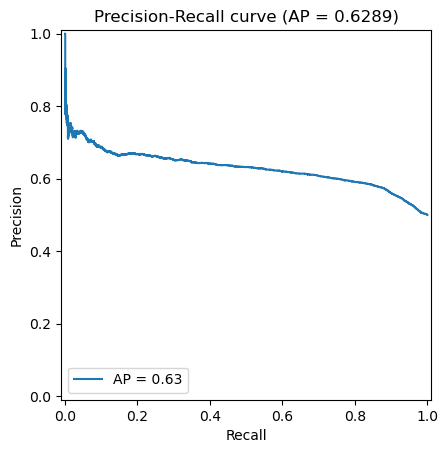

Best threshold by F1: 0.48 F1: 0.6943339018381657


In [18]:
y_true, y_pred, y_probs = outputs(model, test_loader, device=device)
metrics = compute_metrics(y_true, y_pred, y_probs)
print(metrics['report'])
plot_confusion_matrix(y_true, y_pred, normalize=None)   # or normalize='true'
# plt.savefig("confusion.png", bbox_inches="tight")
plot_roc_curve(y_true, y_probs)
# plt.savefig("roc.png", bbox_inches="tight")
plot_precision_recall(y_true, y_probs)
# plt.savefig("precisionrecall.png", bbox_inches="tight")
best_t, best_f1, sweep = threshold_sweep(y_true, y_probs)
print("Best threshold by F1:", best_t, "F1:", best_f1)

## Transformer: Sequence-to-sequence learning

### 11.5 Beyond text classification: Sequence-to-sequence learning

- Takes a sequeence as input and returns a new sequence]
- Successful applications
    - Machine translation
    - Text summarization
    - Question answering
    - Chatbots
    - Text generation

- During training
    - encoder: turns source sequence into an intermediate representation
    - decoder: predicts the next token $i$ in the target sequence by looking at both previous tokens $(0$ to $i-1)$ and encoded source sequence

- During inference
    - No access to the target sequence, generate it one token at a time
    - Encoded source seuqence from the encoder
    - Decoder looks at encoded source sequence and an initial "seed" token such as "[start]" to predict the first real token
    - Predicted sequence so far is sent back into the decoder to generate the next token until generating a stop token such as "[end]"

11.5.3 Sequence-tosequence learning with Transformer

Recall for sequence to sequence learning

- Accuracy is not a great metric, during inference past token predictions may be wrong
- BLEU scores

- Inference split encoder/decoder to only use encoder once on source

- **Transformer encoder:** reads in the source sequence and produces an encoded representation of it keeping the encoded representation in a sequence format. It is a sequence of context aware embedding vectors
- **Transformer decoder:** reads tokens $0,\dots,N$ in the target input sequence and tries to predict the $N+1$ token in the shifted target output sequence. 
    - Uses neural attention to identify which tokens in the encoded source sentence are most closely related to the target token
    - Target sequence serves as the attention query used to pay closer attention to different parts of the source sequence
    - Source sequence will be both the keys and values

<p align="center">
  <img src="images/transformer.png" alt="transformer" width="300"/>
</p>

Transformer Decoder

- Similar to encoder
- Cross-attention: extra attention block in between the self attention block for the target sequence and the dense linear layers in the exit block
    - Query: self attention target input
    - Keys: encoded source
    - Values: encoded source

- Need causal padding
    - RNN: looks at input one step ata time, have access to steps $0,\dots,N$ to generate ouput step $N$ or token $N+1$ 
    - Transformer: order agnostic, looks at entire target sequence at once 
        - But if it uses the entire input, it would learn to copy input step $N+1$ to location $N$ in the output, but would be useless for inference since the input steps beyond $N$ will not be available
        - Solution: mask the upper half of the pairwise attention matrix to prevent the model from paying any attention to information from the future
        - i.e. only tokens $0,\dots,N$ in the target sequence should be used to determine target token $N+1$

- Note: Transformer encoder and decoder are shape invariant which means you can stack many of them to create a more powerful encoder or decoder.

In [1]:
'''
Process data
'''
from utils_seq2seq import *
# load text file, create pairs, standardize
text_file = 'data/datasets/spa-eng/spa.txt'
pairs = []
with open(text_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split("\t")
        if len(parts) < 2:
            continue
        en, es = parts[0], parts[1]
        pairs.append((english_standardize(en), "[start] "+spanish_standardize(es)+" [end]"))

# shuffle + split
random.seed(0)
random.shuffle(pairs)
n = len(pairs)
n_val = int(0.15 * n)
n_test = n_val
n_train = n - n_val - n_test
train_pairs = pairs[:n_train]
val_pairs = pairs[n_train:n_train+n_val]
test_pairs = pairs[n_train+n_val:]

# Tokenize
train_source_tokens = [tokenize_text(p[0]) for p in train_pairs]
train_target_tokens = [tokenize_text(p[1]) for p in train_pairs]

max_seq_length = find_max_seq_length(train_source_tokens+train_target_tokens)

# Index
max_vocab_size = 15000
min_word_freq = 1
source_vocab, source_inv = build_vocab(train_source_tokens, max_size=max_vocab_size, min_freq=min_word_freq)
target_vocab, target_inv = build_vocab(train_target_tokens, max_size=max_vocab_size, min_freq=min_word_freq)

pad_idx_source = source_vocab["<pad>"]
pad_idx_target = target_vocab["<pad>"]
unk_idx_target = target_vocab["<unk>"]

train_dataset = TranslationDataset(train_pairs, source_vocab, target_vocab)
val_dataset = TranslationDataset(val_pairs, source_vocab, target_vocab)
test_dataset = TranslationDataset(test_pairs, source_vocab, target_vocab)

collate_function = partial(collate_seq2seq, source_pad_idx=pad_idx_source, target_pad_idx=pad_idx_target)

batch_size = 64
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True,
                          collate_fn=collate_function)
val_loader   = DataLoader(val_dataset, 
                          batch_size=batch_size, 
                          shuffle=False,
                          collate_fn=collate_function)

Device:  cpu


In [ ]:
epochs = 12
model = TransformerSeq2Seq(source_vocab_size = len(source_vocab), 
                            target_vocab_size = len(target_vocab), 
                            embed_dim=128, 
                            hidden_dim=64, 
                            num_heads=2,
                            num_layers=2,
                            pad_idx_source=pad_idx_source, 
                            pad_idx_target=pad_idx_target,
                            max_source_len = max_seq_length,
                            max_target_len = max_seq_length).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx_target)

In [3]:
train_pairs[0]

('yesterday i met mary on the street',
 '[start] ayer me encontré con mary en la calle [end]')

In [4]:
number_of_parameters = 0
for i,params in enumerate(model.parameters()):
  number_of_parameters += params.flatten().shape[0]
print('Number of Parameters: ', number_of_parameters)

Number of Parameters:  5971354


In [5]:
torchinfo.summary(model, 
                  input_data=[torch.randint(0,len(source_vocab),(batch_size,20)), 
                              torch.randint(1,10,(batch_size,)), 
                              torch.randint(0,len(target_vocab),(batch_size,20)),
                              torch.randint(1,10,(batch_size,)) ],
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  depth=3 )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
TransformerSeq2Seq                       [64, 20]                  [64, 20, 15002]           --                        True
├─Embedding: 1-1                         [64, 20]                  [64, 20, 128]             1,650,688                 True
├─SinusoidalPositionalEmbedding: 1-2     [64, 20, 128]             [64, 20, 128]             --                        --
├─Embedding: 1-3                         [64, 20]                  [64, 20, 128]             1,920,256                 True
├─SinusoidalPositionalEmbedding: 1-4     [64, 20, 128]             [64, 20, 128]             --                        --
├─ModuleList: 1-5                        --                        --                        --                        True
│    └─TransformerEncoder: 2-1           [64, 20, 128]             [64, 20, 128]             --                        True
│    │ 

In [6]:
training_history = training_seq2seq(train_loader,
                                        val_loader,
                                        epochs,
                                        loss_fn,
                                        model,
                                        optimizer,
                                        regularize=False)

Epoch 1 | Train Loss: 3.7495 | Val Loss: 2.5479 | Best Val Loss: 2.5479
Epoch 2 | Train Loss: 2.2423 | Val Loss: 2.0500 | Best Val Loss: 2.0500
Epoch 3 | Train Loss: 1.7696 | Val Loss: 1.8786 | Best Val Loss: 1.8786
Epoch 4 | Train Loss: 1.5132 | Val Loss: 1.7865 | Best Val Loss: 1.7865
Epoch 5 | Train Loss: 1.3479 | Val Loss: 1.7603 | Best Val Loss: 1.7603
Epoch 6 | Train Loss: 1.2318 | Val Loss: 1.7288 | Best Val Loss: 1.7288
Epoch 7 | Train Loss: 1.1454 | Val Loss: 1.7281 | Best Val Loss: 1.7281
Epoch 8 | Train Loss: 1.0729 | Val Loss: 1.7027 | Best Val Loss: 1.7027
Epoch 9 | Train Loss: 1.0137 | Val Loss: 1.7090 | Best Val Loss: 1.7027
Epoch 10 | Train Loss: 0.9637 | Val Loss: 1.7095 | Best Val Loss: 1.7027
Epoch 11 | Train Loss: 0.9206 | Val Loss: 1.7088 | Best Val Loss: 1.7027
Epoch 12 | Train Loss: 0.8809 | Val Loss: 1.7088 | Best Val Loss: 1.7027
Training Complete. Total Time (s): 5491.72


In [7]:
test_dataset.__getitem__(0)

{'source': [77, 217, 44, 434], 'target': [2, 9, 1439, 19, 300, 40, 135, 3]}

In [8]:
@torch.inference_mode()
def translate(model, source_seq, source_lengths, target_vocab, max_target_len=50, device="cpu"):
    model.eval()

    start_idx = target_vocab["[start]"]
    end_idx   = target_vocab["[end]"]

    source_seq = source_seq.to(device)
    source_lengths = source_lengths.to(device)

    # Initialize with [start]
    generated = torch.tensor([[start_idx]], device=device)

    for _ in range(max_target_len):
        # Forward pass with current prefix
        logits = model(source_seq, source_lengths, generated, torch.tensor([generated.size(1)], device=device))
        
        # Get next-token logits from last position
        next_token = logits[:, -1, :].argmax(dim=-1)

        # Append to sequence
        generated = torch.cat([generated, next_token.unsqueeze(0)], dim=1)

        if next_token.item() == end_idx:
            break

    # Drop the start token
    return generated[0, 1:].tolist()

In [18]:
def convert_token_ids(token_idxs,vocab_inv):
    true_list = []
    for idx in token_idxs:
        if vocab_inv[idx] not in {"[start]","[end]"}:
            true_list.append(vocab_inv[idx])
    return ' '.join(true_list)

In [19]:
target = translate(model, 
                   source_seq=torch.tensor(test_dataset.__getitem__(0)['source']).unsqueeze(0), 
                   source_lengths=torch.tensor(len(test_dataset.__getitem__(0)['source'])).reshape(1,1), 
                   target_vocab = target_vocab, 
                   max_target_len=max_seq_length, 
                   device="cpu")

In [20]:
true_source = convert_token_ids(token_idxs=test_dataset.__getitem__(0)['source'],
                  vocab_inv=source_inv)
true_target = convert_token_ids(token_idxs=test_dataset.__getitem__(0)['target'],
                  vocab_inv=target_inv)
pred_target = convert_token_ids(token_idxs=target,
                  vocab_inv=target_inv)

print('True Source: ', true_source)
print('True Target: ', true_target)
print('Pred Target: ', pred_target)

True Source:  ill call him tonight
True Target:  la llamaré por teléfono esta noche
Pred Target:  le voy a llamar esta noche
